In [1]:
# import sys
# !conda install --yes --prefix {sys.prefix} fbprophet
# !conda install --yes basemap
# !conda install --yes -c conda-forge basemap
# !conda install --yes -c conda-forge basemap-data-hires
import os
import conda

## Start hack to get Basemap to work while Prophet is also installed
## Do not change order of imports!
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
from mpl_toolkits.basemap import Basemap ## this has to come after the file hack above
import fbprophet ## this and the next line have to come after importing Basemap
from fbprophet import Prophet ## in this order
## end hack
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np
import matplotlib.patches as mpatches
print('This must be at least version 0.20.0')
print('If it is not, you must upgrade conda and scikit-learn.')
print(sklearn.__version__)
import warnings
warnings.filterwarnings('ignore')
import googlemaps
from datetime import datetime
import local
gmaps = googlemaps.Client(key=local.GOOGLE_MAP_API_KEY)
from IPython.display import display
import pprint
pp = pprint.PrettyPrinter(indent=4)
# from jupyterthemes import jtplot
# jtplot.style()

This must be at least version 0.20.0
If it is not, you must upgrade conda and scikit-learn.
0.20.1


In [2]:
zillow_drop_list = ['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']
pgh_drop_list = ['PROPERTYCITY', 'PROPERTYSTATE', 'MUNICODE', 'DEEDBOOK', 'DEEDPAGE', 'SALEDESC', 'INSTRTYP', 'INSTRTYPDESC', 'PGH_COUNCIL_DISTRICT', 'PGH_WARD', 'PGH_PUBLIC_WORKS_DIVISION', 'PGH_POLICE_ZONE', 'PGH_FIRE_ZONE', 'TRACT', 'RECORDDATE', 'BLOCK_GROUP','SCHOOLCODE', 'SCHOOLDESC', 'MUNICODE','MUNIDESC', 'MUNICIPALITY']
arrests_drop_list = ['_id', 'PK', 'CCR', 'INCIDENTLOCATION', 'INCIDENTZONE', 'INCIDENTTRACT', 'COUNCIL_DISTRICT', 'PUBLIC_WORKS_DIVISION']
valid_codes = ['0', 'U', 'UR', '14', '16', '33', '34', '36', '37', 'BK']

In [3]:
pgh_sales = pd.read_csv('data/pgh_re_2013-2018.csv')
pgh_sales = pgh_sales.loc[pgh_sales.MUNICIPALITY == 'Pittsburgh']
arrests = pd.read_csv('data/arrests_2016.csv')
pgh_city_zip_list = list(pgh_sales.PROPERTYZIP)

In [4]:
zip_income = pd.read_csv('data/zip_income.csv')
demographics = pd.read_csv('data/ACS_14_5YR_S1903_with_ann.csv')
zillow_medians = pd.read_csv('data/Zip_Zhvi_SingleFamilyResidence.csv', engine='python')
zillow_medians.drop(zillow_drop_list, axis=1, inplace=True)
pgh_sales.drop(pgh_drop_list, axis=1, inplace=True)
arrests.drop(arrests_drop_list, axis=1, inplace=True)
zillow_medians.rename(columns={'RegionName': 'zip_code'}, inplace=True)
pgh_time_medians = zillow_medians.loc[zillow_medians.zip_code.isin(pgh_city_zip_list)]

In [5]:
def drop_zeros(x):
    return(str(x).replace('.0', ''))

In [6]:
pgh_sales.PROPERTYHOUSENUM = pgh_sales.PROPERTYHOUSENUM.apply(drop_zeros)
pgh_sales.PROPERTYZIP = pgh_sales.PROPERTYZIP.apply(drop_zeros)

In [7]:
join_list = ['PROPERTYHOUSENUM', 'PROPERTYFRACTION', 
             'PROPERTYADDRESSDIR', 'PROPERTYADDRESSSTREET', 
             'PROPERTYADDRESSSUF', 'PROPERTYADDRESSUNITDESC', 
             'PROPERTYUNITNO']
street_address = pgh_sales[join_list].apply(lambda x: ' '.join(x.astype(str)).strip().replace(' nan', ''), axis=1)
pgh_sales.drop(join_list, axis=1, inplace=True)
pgh_sales = pgh_sales.assign(street_address=street_address)
pgh_sales.rename(str.lower, axis='columns', inplace=True)
pgh_sales.rename(columns={'propertyzip': 'zip_code'}, inplace=True)
pgh_sales = pgh_sales.loc[pgh_sales.salecode.isin(valid_codes)]
pgh_sales.shape

(20517, 7)

In [8]:
arrests.columns = ['age', 'gender', 'race', 'arresttime', 'location', 'offenses', 'neighborhood', 'lng', 'lat']
arrests = arrests.assign(zip_code=arrests.location.map(lambda x: x[-5:]))
arrests = arrests.loc[arrests.zip_code.isin(pgh_sales.zip_code)]
zip_income.columns = ['zip_code', 'median_income', 'mean_income']
zip_income.zip_code = zip_income.zip_code.astype(str)

In [9]:
demo_keep = {
    'Geography': 'zip_code', 
    'Total; Estimate; Households': 'pop',
    'Total; Estimate; Households - One race-- - White': 'white_pct',
    'Total; Estimate; Households - One race-- - Black or African American': 'black_pct'
            }
demographics = demographics[list(demo_keep.keys())]
demographics.rename(columns=demo_keep, inplace=True)

In [10]:
demographics.zip_code = demographics.zip_code.map(lambda x: x.replace('ZCTA5 ', '').strip())
demographics = pd.merge(demographics, zip_income, on='zip_code')

In [11]:
pgh_city_zip_list = list(map(lambda x: str(x).replace('.0', ''), pgh_city_zip_list))
pgh_city_zip_list
demographics = demographics.loc[demographics.zip_code.isin(pgh_city_zip_list)]
demographics.head()

,zip_code,pop,white_pct,black_pct,median_income,mean_income
74,15106,8736,93.6,5.4,49438,65851
79,15120,8567,80.6,17.6,42157,55258
80,15122,8735,88.4,10.3,47436,62063
98,15201,5999,76.3,19.6,51201,73644
99,15202,9301,90.9,6.7,46541,62455


In [12]:
arrests.set_index('zip_code', inplace=True)
demographics.set_index('zip_code', inplace=True)
arrests = arrests.assign(pop=demographics['pop'])
arrests.reset_index(inplace=True)
demographics.reset_index(inplace=True)

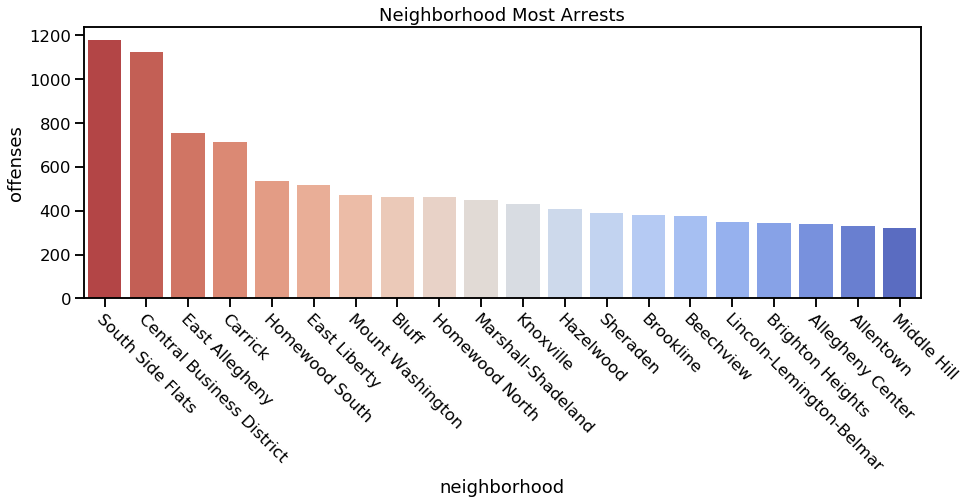

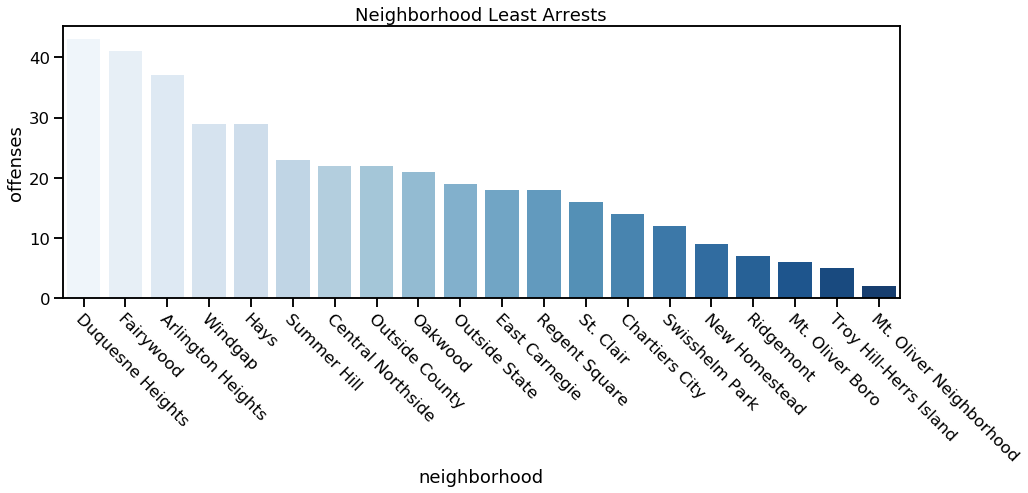

In [13]:
sns.set_context('talk')
arrests_neigh = arrests.groupby(['neighborhood'], as_index=False).agg({'offenses': 'count'})
arrests_neigh.sort_values(by='offenses', ascending=False, inplace=True)
arrests_plot = {
    'Neighborhood Most Arrests': arrests_neigh.head(20),
    'Neighborhood Least Arrests': arrests_neigh.tail(20)
}
colors = ['coolwarm_r', 'Blues']
counter = 0
for name, df in arrests_plot.items():
    plt.figure(figsize=(15, 5))
    sns.barplot(x='neighborhood', y='offenses', data=df, palette=colors[counter])
    plt.xticks(rotation=-45, ha='left',  rotation_mode='anchor')
    plt.title(name)
    counter += 1
plt.show()

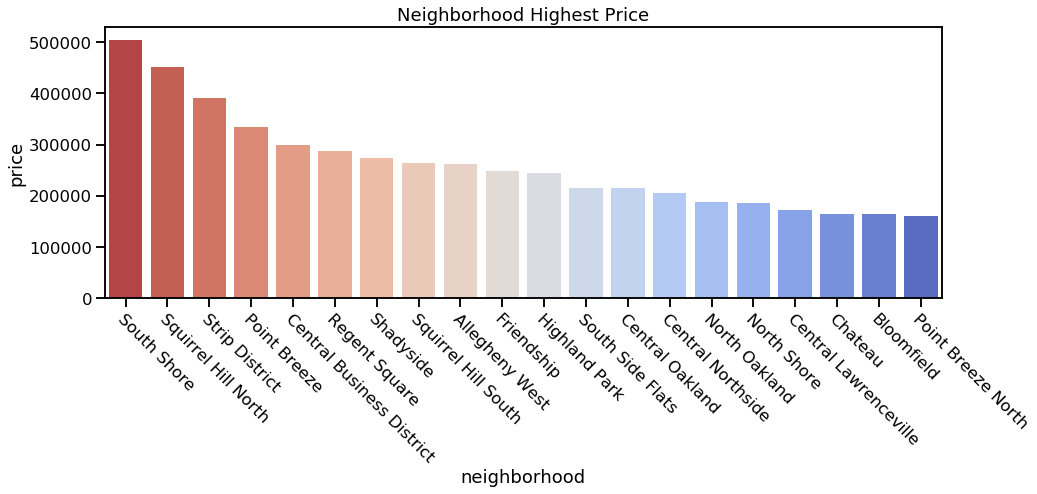

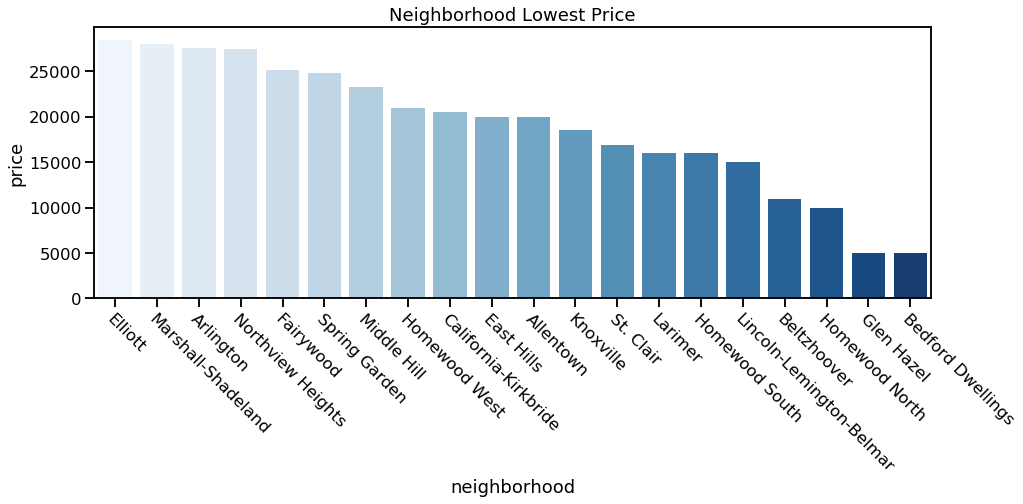

In [14]:
sales_neigh = pgh_sales.groupby(['neighborhood'], as_index=False).agg({'price': 'median'})
sales_neigh.sort_values(by='price', ascending=False, inplace=True)
sales_plot = {
    'Neighborhood Highest Price': sales_neigh.head(20),
    'Neighborhood Lowest Price': sales_neigh.tail(20)
}
colors = ['coolwarm_r', 'Blues']
counter = 0
for name, df in sales_plot.items():
    plt.figure(figsize=(15, 5))
    sns.barplot(x='neighborhood', y='price', data=df, palette=colors[counter])
    plt.xticks(rotation=-45, ha='left',  rotation_mode='anchor')
    plt.title(name)
    counter += 1
plt.show()

In [15]:
city_median = pgh_time_medians.iloc[:, 1:].median()

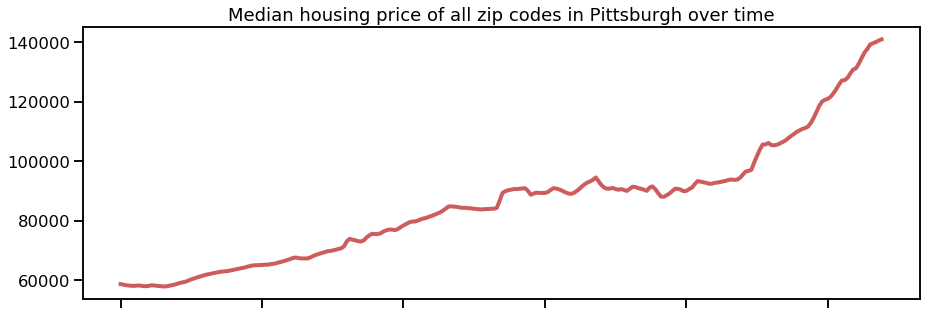

In [16]:
plt.figure(figsize=(15, 5))
city_median.plot(linewidth=4, color='indianred')
plt.title('Median housing price of all zip codes in Pittsburgh over time')
plt.show()

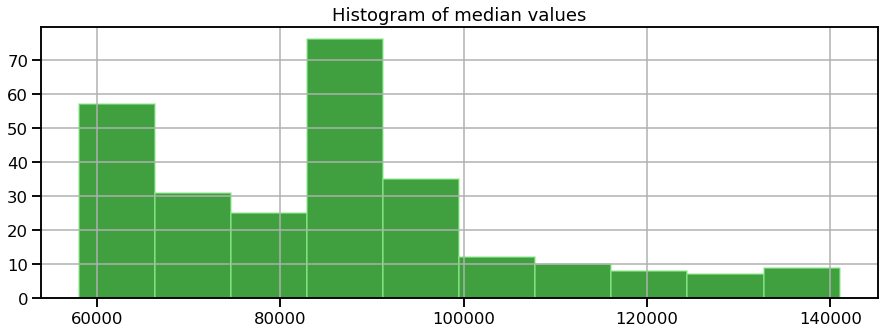

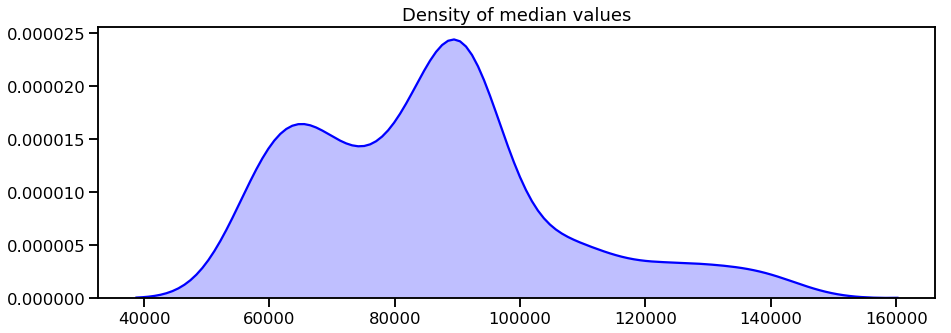

In [17]:
city_median.index = pd.to_datetime(city_median.index)
city_median.hist(figsize=(15, 5), color='g', alpha=.75, ec='lightgreen')
plt.title('Histogram of median values')
plt.show()
plt.figure(figsize=(15, 5))
sns.kdeplot(city_median, color='b', shade=True)
plt.title('Density of median values')
plt.show()

In [18]:
pgh_time_series = pgh_time_medians.copy()
pgh_time_series.rename(columns={'zip_code': 'ds'}, inplace=True)
pgh_time_series = pgh_time_series.set_index('ds').T
pgh_time_series.index = pd.to_datetime(pgh_time_series.index)

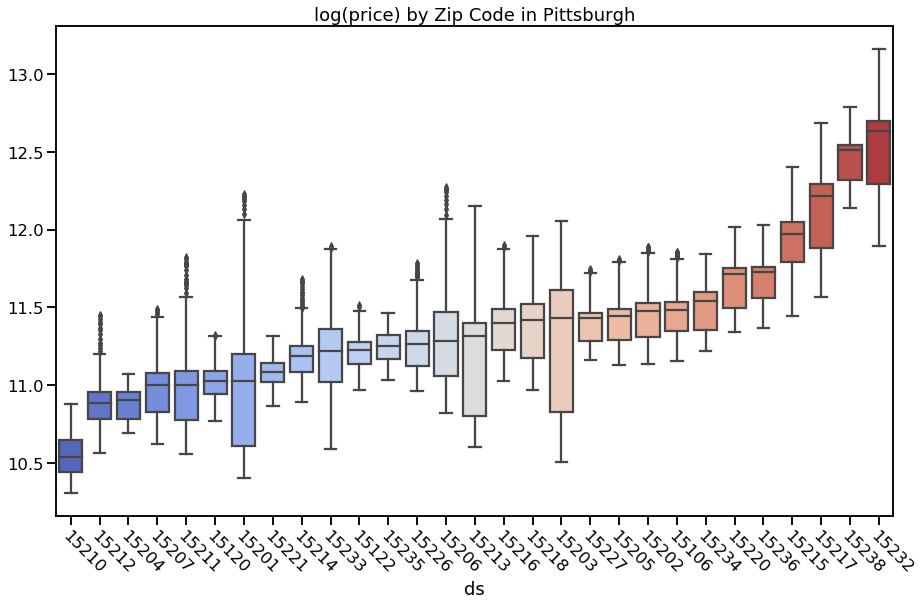

In [19]:
box_set = pgh_time_series.reset_index(drop=True)
plt.figure(figsize=(15, 9))
sns.boxplot(data=np.log(box_set), order=box_set.median().sort_values(ascending=True).index, palette='coolwarm')
plt.xticks(rotation=-45, ha='left', rotation_mode='anchor')
plt.title('log(price) by Zip Code in Pittsburgh')
plt.show()

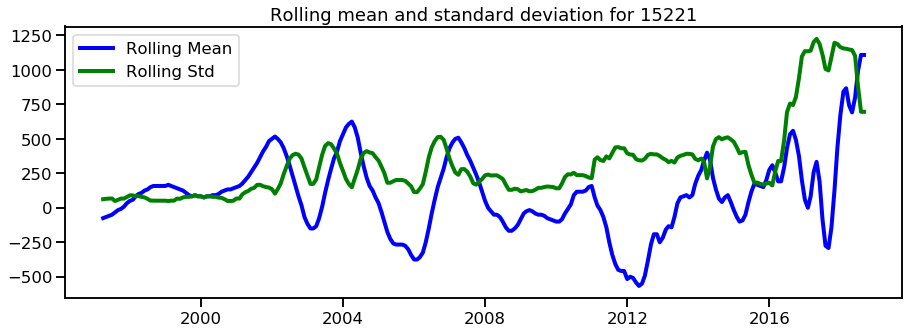

'Test results for zip 15221'

Test Statistic       -4.044854
p-value               0.001193
Critical Value 1%    -3.456155
Critical Value 5%    -2.872897
Critical Value 10%   -2.572822
dtype: float64

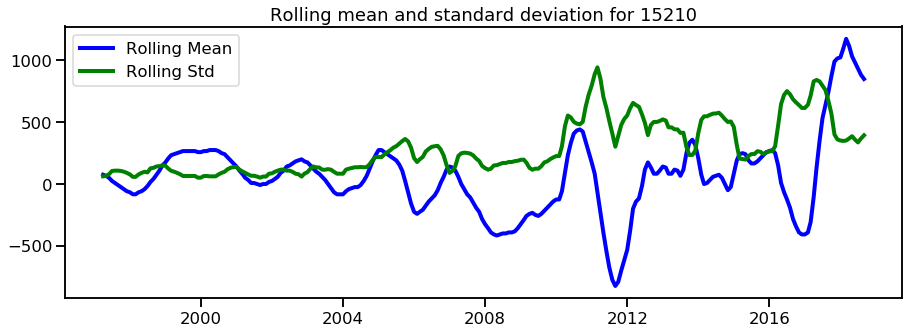

'Test results for zip 15210'

Test Statistic       -4.384561
p-value               0.000316
Critical Value 1%    -3.455461
Critical Value 5%    -2.872593
Critical Value 10%   -2.572660
dtype: float64

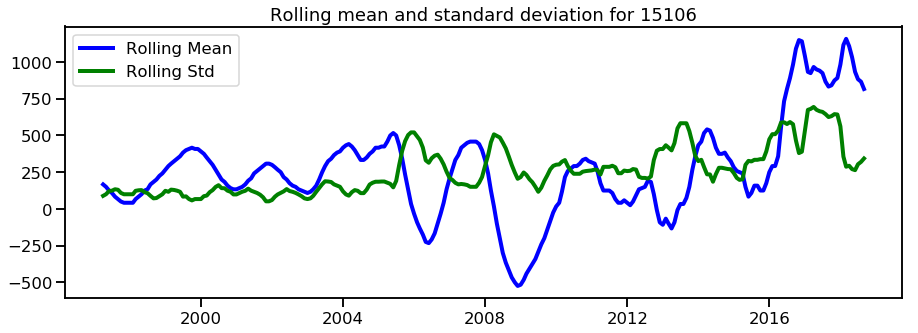

'Test results for zip 15106'

Test Statistic       -3.928295
p-value               0.001836
Critical Value 1%    -3.455175
Critical Value 5%    -2.872468
Critical Value 10%   -2.572593
dtype: float64

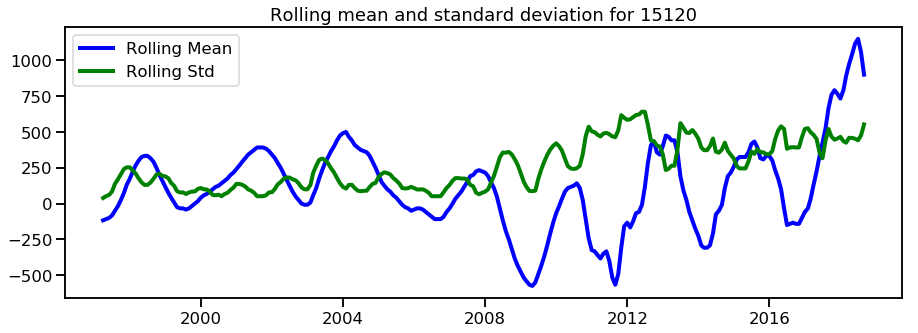

'Test results for zip 15120'

Test Statistic       -5.358437
p-value               0.000004
Critical Value 1%    -3.455953
Critical Value 5%    -2.872809
Critical Value 10%   -2.572775
dtype: float64

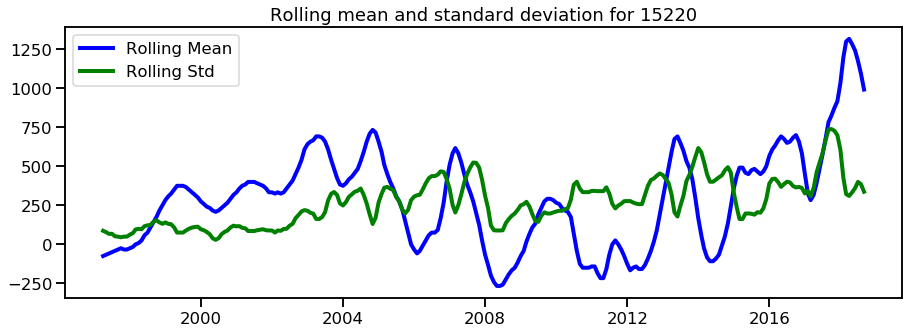

'Test results for zip 15220'

Test Statistic       -4.137556
p-value               0.000839
Critical Value 1%    -3.455270
Critical Value 5%    -2.872509
Critical Value 10%   -2.572615
dtype: float64

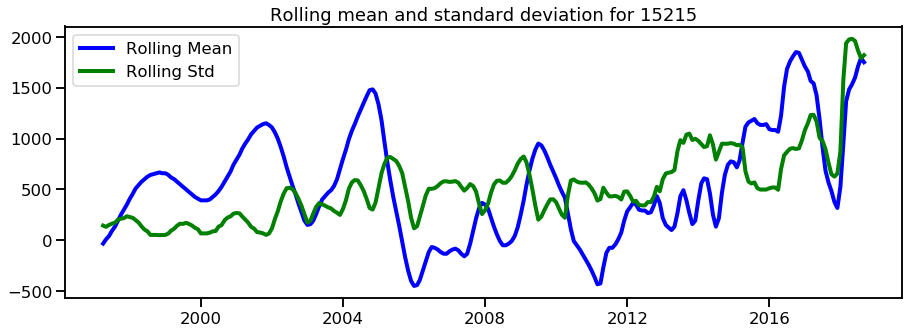

'Test results for zip 15215'

Test Statistic       -5.353022
p-value               0.000004
Critical Value 1%    -3.455270
Critical Value 5%    -2.872509
Critical Value 10%   -2.572615
dtype: float64

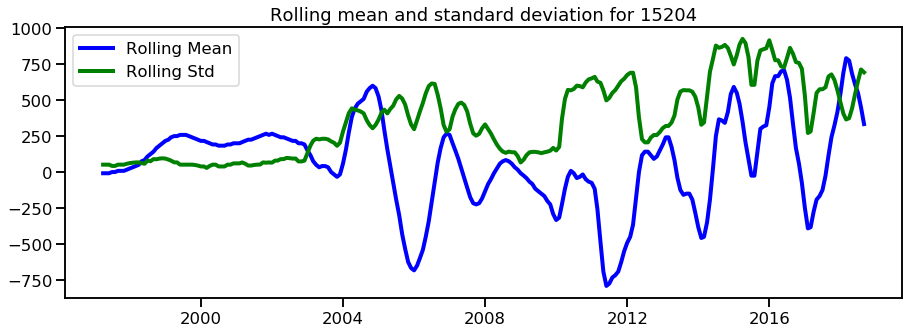

'Test results for zip 15204'

Test Statistic       -4.036288
p-value               0.001232
Critical Value 1%    -3.456155
Critical Value 5%    -2.872897
Critical Value 10%   -2.572822
dtype: float64

In [20]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(name: str, timeseries: pd.Series): 
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    for key,value in dftest[4].items():
        dfoutput[f'Critical Value {key}'] = value
    return(dfoutput)

def plot_time_series(name, time_series):
    plt.figure(figsize=(15, 5))
    rolmean = time_series.rolling(12).mean()
    rolstd = time_series.rolling(12).std()
    mean = plt.plot(rolmean, color='b', label='Rolling Mean', linewidth=4)
    std = plt.plot(rolstd, color='g', label='Rolling Std', linewidth=4)
    plt.legend(loc='best')
    plt.title(f'Rolling mean and standard deviation for {name}')
    plt.show()

sta_series = {}
series_orig = {}
for series in pgh_time_series.iteritems():
    temp_series = series[1].diff()
    temp_series.dropna(inplace=True)
    name = series[0]
    results = test_stationarity(name, temp_series)
    if results[0] < results[2] and results[1] < .05:
        series_orig[name] = series[1]
        sta_series[name] = temp_series
        plot_time_series(name, temp_series)
        display(f'Test results for zip {name}', results)

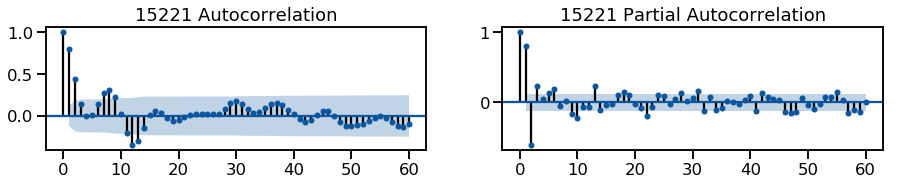

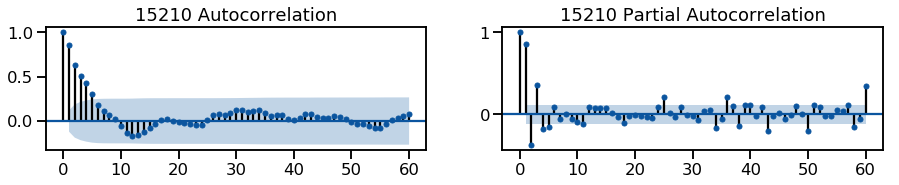

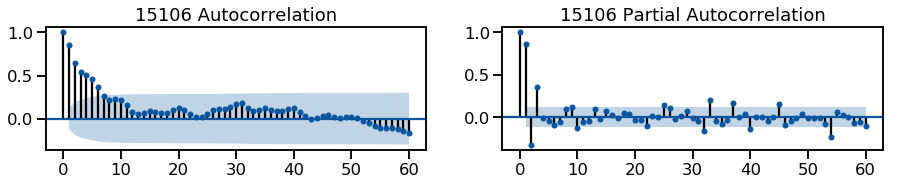

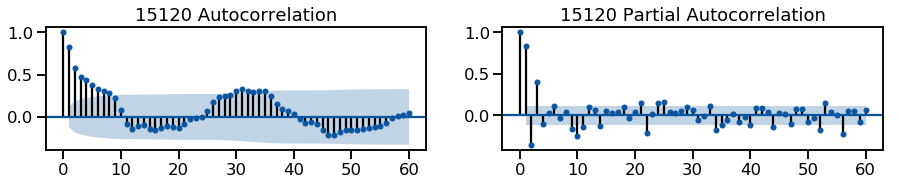

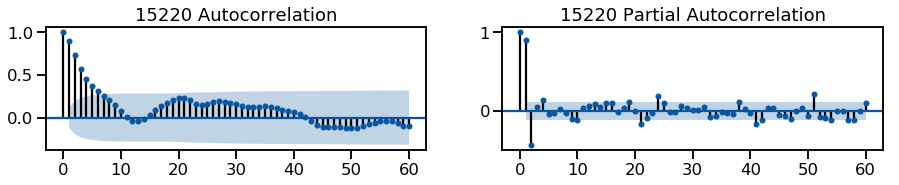

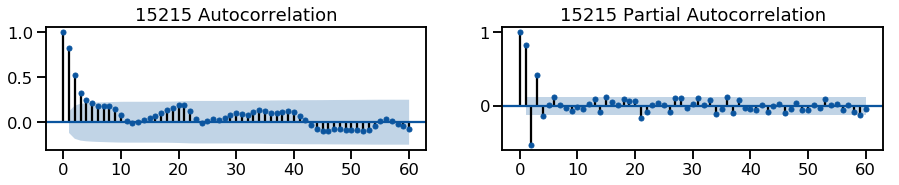

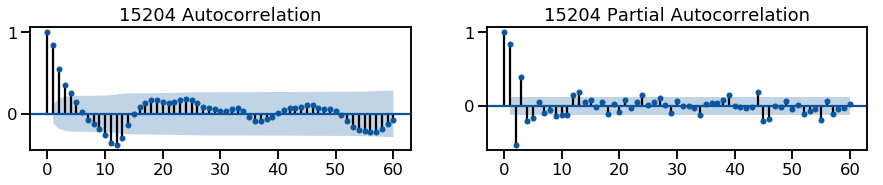

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
sns.set_context('talk')
sns.set_palette('Blues_r')
for name, df in sta_series.items():
    plt.figure(figsize=(15, 5))
    plt.subplot(221); plot_acf(df, lags=60, ax=plt.gca(), title=f'{name} Autocorrelation')
    plt.subplot(222); plot_pacf(df,  lags=60, ax=plt.gca(), title=f'{name} Partial Autocorrelation')


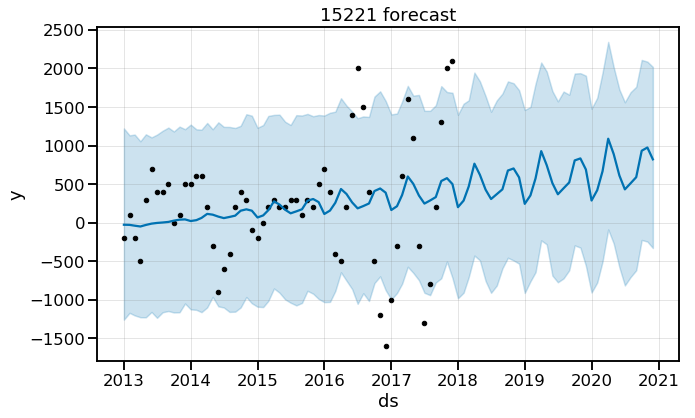

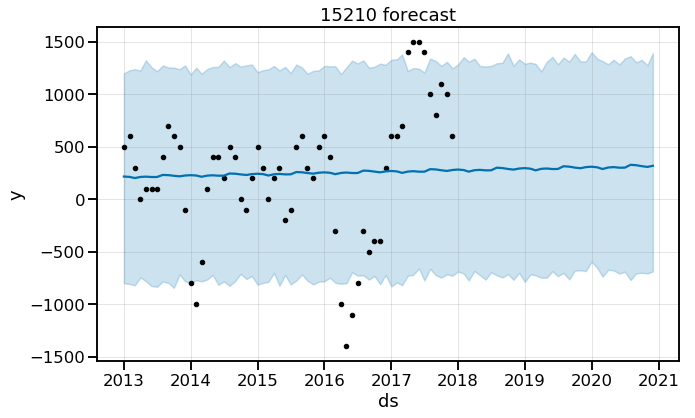

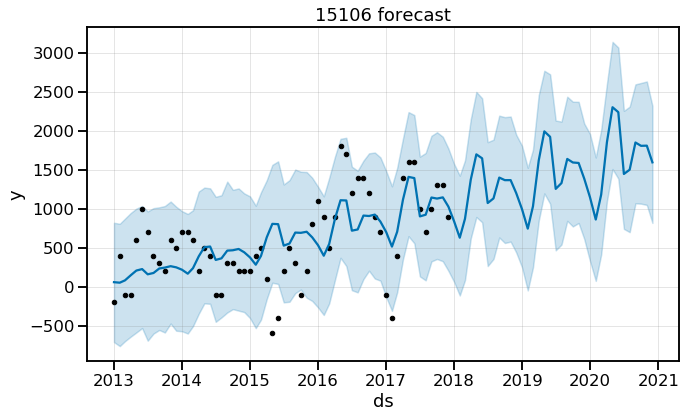

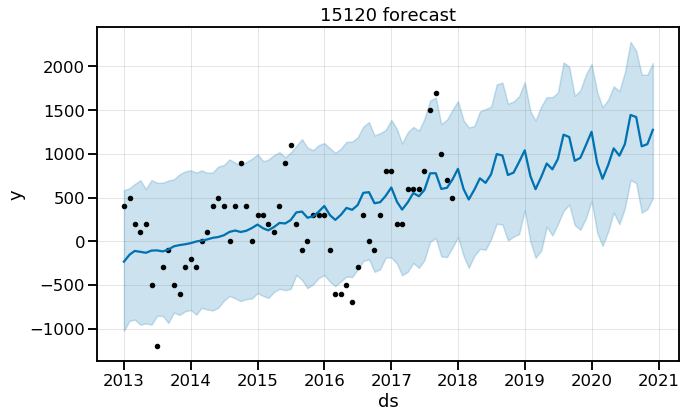

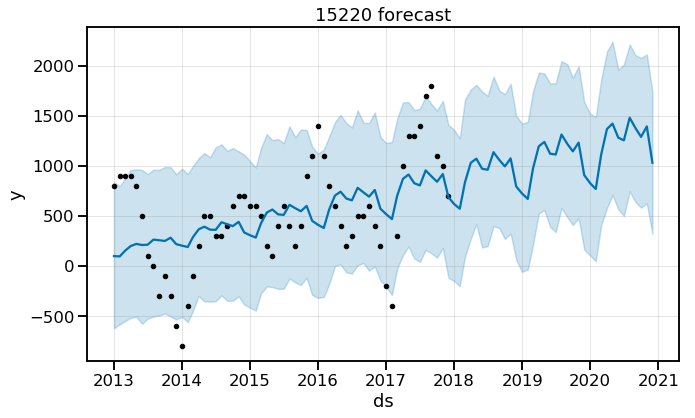

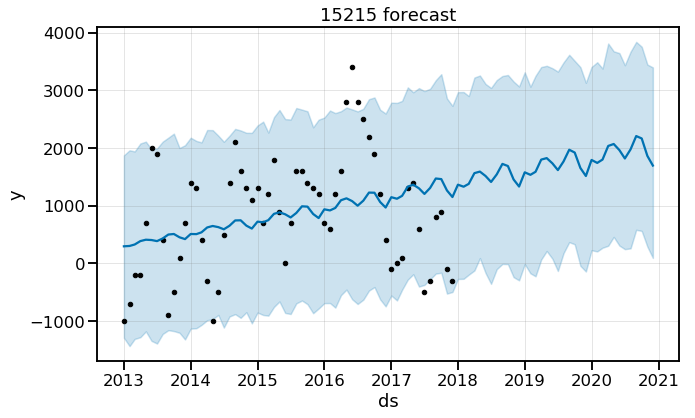

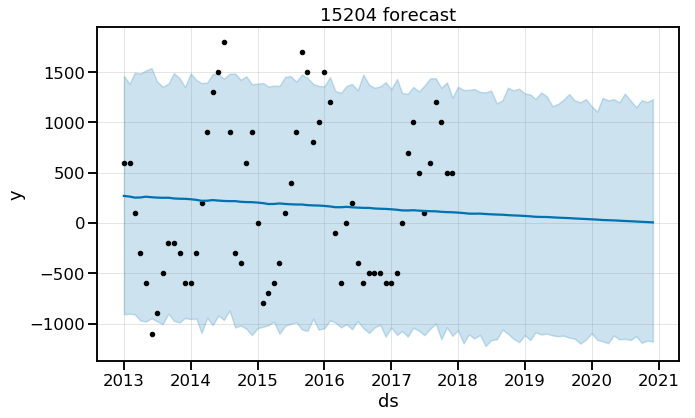

In [22]:
forecasts = {}
for name, df in sta_series.items():
    name = f'{name} forecast'
    temp = pd.DataFrame(df['2013':'2017'])
    temp.reset_index(inplace=True)
    temp.columns = ['ds', 'y']
    prophet_model = Prophet(
        interval_width=0.9, 
        weekly_seasonality=False, 
        daily_seasonality=False,
        seasonality_mode='multiplicative'
    )
    prophet_model.fit(temp)
    future = prophet_model.make_future_dataframe(periods=12*3, freq='M')
    forecast = prophet_model.predict(future)
    forecasts[name] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    prophet_model.plot(forecast)
    plt.title(name)
    plt.show()

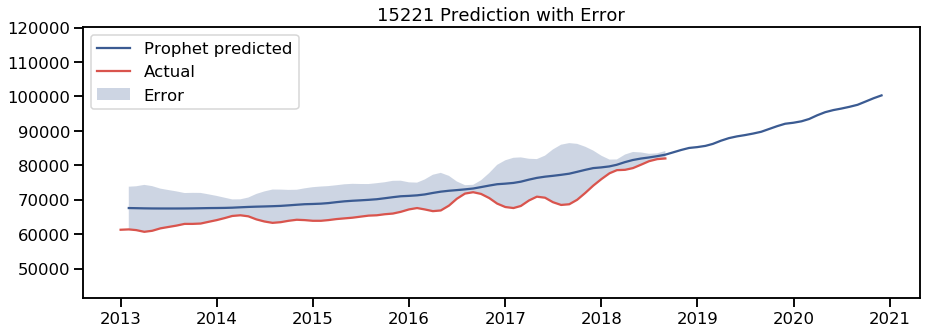

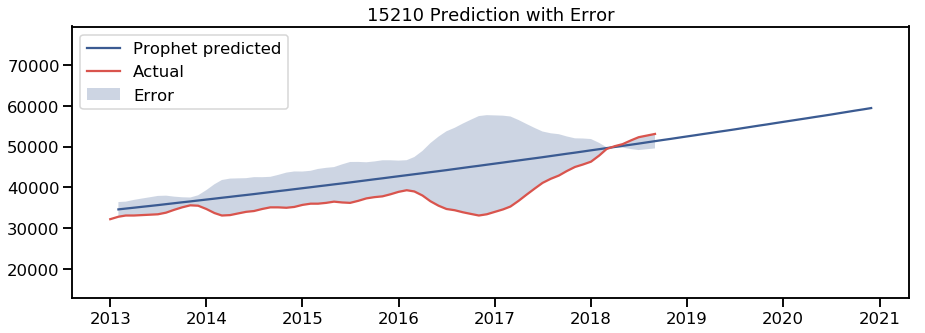

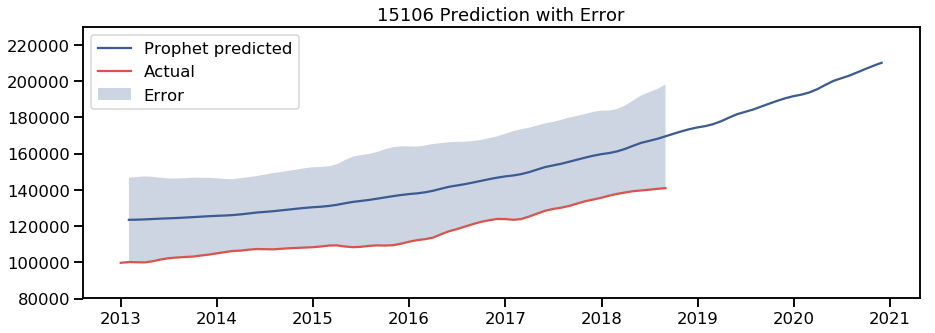

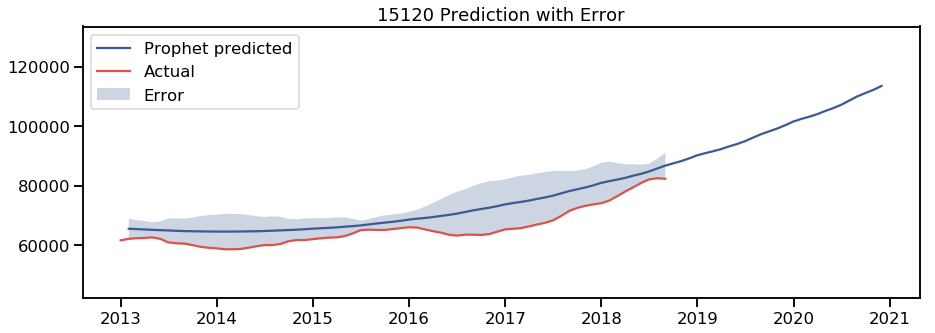

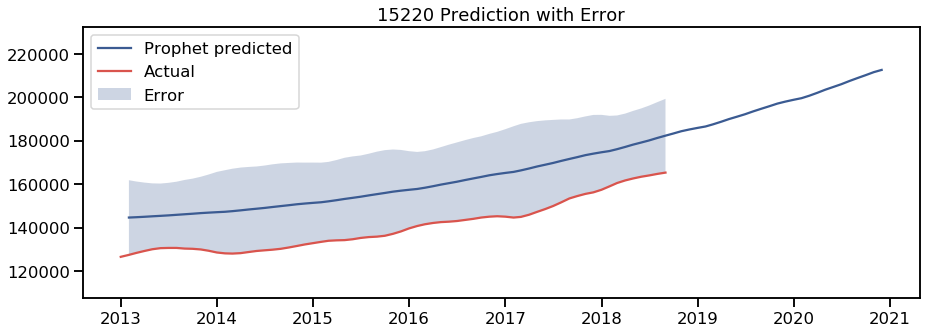

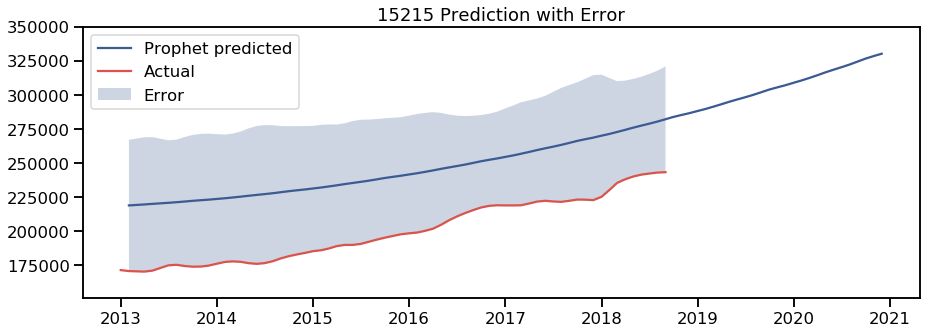

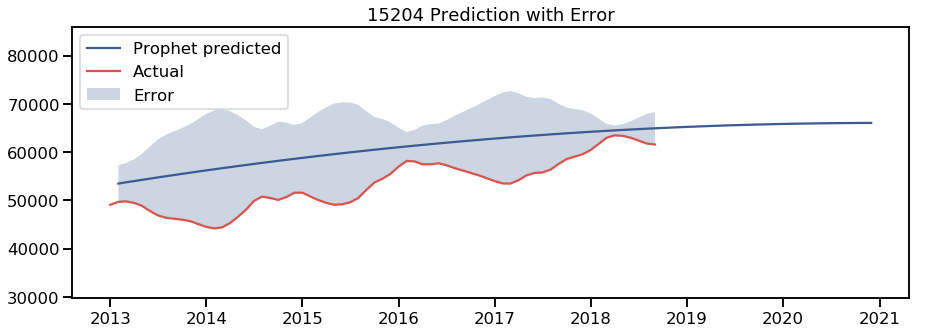

In [23]:
colors = ['denim blue', 'pale red']
sns.set_palette(sns.xkcd_palette(colors))
deltas = {}
for name, df in series_orig.items():
    temp_2018 = df.iloc[-20:]

    forecast = forecasts[f'{name} forecast']
    _pred = forecast.loc[forecast.ds > '2013']
    _pred = _pred.loc[_pred.ds < '2021']
    prophet_predict = np.r_[
        temp_2018.iloc[0],
        _pred.yhat.iloc[1:]
    ].cumsum()
    error = np.abs(df['2013-02-01':] - prophet_predict[:68])
    delta = prophet_predict[-1] - temp_2018[-1]
    deltas[name] = {
        'delta': delta,
        'orig': temp_2018[-1],
        'pred': prophet_predict[-1],
        'error': np.median(error),
        'delta_minus_error': delta - np.median(error),
        'median_price_2018': temp_2018.median()
    }
    plt.figure(figsize=(15, 5))
    plt.plot(_pred.ds, prophet_predict, label='Prophet predicted')
    plt.plot(df['2013':], label='Actual')
    x = pd.to_datetime(df['2013-02-01':].index)
    y = prophet_predict[:68]
    plt.fill_between(
        x, 
        y+error,
        y-error, 
        alpha=0.25,
        label='Error'
    )
    plt.title(f'{name} Prediction with Error')
    plt.legend(loc='upper left')
    plt.ylim(bottom=(y[0]-error[0])-20000, top=np.max(prophet_predict)+20000)

In [24]:
investment_zips = pd.DataFrame(deltas).T
investment_zips.assign(
    pct_delta=lambda x: (x['delta_minus_error'] / x['median_price_2018']) * 100
).sort_values(by='pct_delta', ascending=False)

,delta,delta_minus_error,error,median_price_2018,orig,pred,pct_delta
15120,31243.340393,26554.241412,4689.098981,73450.0,82300.0,113543.340393,36.152813
15106,69165.113448,45511.812681,23653.300767,134250.0,141000.0,210165.113448,33.900792
15215,86966.861417,42621.480718,44345.380698,223050.0,243200.0,330166.861417,19.108487
15221,18304.038383,13673.907775,4630.130609,73050.0,82000.0,100304.038383,18.718560
15220,47304.587519,28862.208465,18442.379054,155850.0,165300.0,212604.587519,18.519223
15210,6346.515477,2148.051741,4198.463736,45300.0,53100.0,59446.515477,4.741836
15204,4474.241954,-2790.379584,7264.621538,59350.0,61600.0,66074.241954,-4.701566


In [25]:
import re
pgh_sales_demo = pgh_sales.merge(demographics)
zip_median = pgh_sales_demo.groupby('zip_code', as_index=False).agg({'price': 'median'})
zip_median.rename(columns={'price': 'zip_median_price'}, inplace=True)
pgh_sales_demo = pgh_sales_demo.merge(zip_median)
arrest_counts = arrests.groupby('zip_code', as_index=False).agg({'offenses': 'count'})
arrest_counts.rename(columns={'offenses': 'total_arrests'}, inplace=True)
whole_enchilada = pgh_sales_demo.merge(arrest_counts)
nums = ['white_pct', 'black_pct', 'median_income']
for num in nums: whole_enchilada[num] = pd.to_numeric(whole_enchilada[num]);
whole_enchilada['saledate'] = pd.to_datetime(whole_enchilada['saledate'])
whole_enchilada.street_address = whole_enchilada.street_address.apply(lambda x: re.sub(' +', ' ', x))
whole_enchilada.dropna(inplace=True)
whole_enchilada.drop(whole_enchilada.loc[whole_enchilada.price == whole_enchilada.price.max()].index, inplace=True)

In [26]:
def impute_median(x):
    if x['price'] < 1000:
        x['price'] = x['zip_median_price']
    return x
whole_enchilada = whole_enchilada.apply(impute_median, axis=1)

In [27]:
whole_enchilada = whole_enchilada.loc[whole_enchilada.zip_code.isin(list(investment_zips.index.astype(str)))]

In [28]:
"""
Ran for five or six days and got a lot of data. 
Don't run because it calls Zillow's live api.
"""
# from zillow_call import DataIO
# data_io = DataIO()
# todo_bueno = data_io.call_zillow(whole_enchilada, True)
# final_set = todo_bueno.merge(whole_enchilada, on='parid', how='left')

"\nRan for five or six days and got a lot of data. \nDon't run because it calls Zillow's live api.\n"

In [29]:
"""
This one instead.
"""
final_set = pd.read_csv('data/final_set.csv')

In [30]:
aggregate_attributes = ['zip_median_price', 'total_arrests', 'mean_income', 
                        'median_income', 'black_pct', 'white_pct', 'pop']
cat_attributes = ['street_address', 'neighborhood', 'zip_code', 'year_built']
ind_num_attributes = ['age', 'baths', 'beds', 'lot_size', 'sqft', 'price']
all_num_attributes = aggregate_attributes + ind_num_attributes
final_set[all_num_attributes] = final_set[all_num_attributes].astype('float')
final_set.drop(final_set.loc[final_set.price == final_set.price.max()].index, inplace=True)
final_set.drop(final_set.loc[final_set.sqft <= 300].index, inplace=True)
final_set.drop_duplicates(inplace=True)
way_out_age = final_set.loc[final_set.age == final_set.age.max()]
way_out_age.age = 119
way_out_age.year_built = '1900'
final_set.loc[final_set.age == final_set.age.max()] = way_out_age
final_set.drop(final_set.loc[final_set.baths == final_set.baths.max()].index, inplace=True)
final_set.drop(final_set.loc[final_set.beds == final_set.beds.max()].index, inplace=True)
final_set.drop(final_set.loc[final_set.sqft == final_set.sqft.max()].index, inplace=True)
final_set.drop(final_set.loc[final_set.street_address.str.contains('5321 5TH AVE')].index, inplace=True)

In [31]:
import copy
pd.options.display.float_format = '{:,.2f}'.format
max_to_med = copy.copy(ind_num_attributes)
max_to_med.remove('price')
for var in max_to_med:
    series_median = int(round(final_set[var].median()))
    final_set.loc[final_set[var] == final_set[var].max(), var] = series_median
    final_set.loc[final_set[var].isna(), var] = series_median

In [32]:
final_set.baths = np.ceil(final_set.baths)
final_set.loc[final_set.sqft > 12000, 'sqft'] = final_set.sqft.median()
final_set.loc[final_set.lot_size >= final_set.lot_size.median() + (2 * final_set.lot_size.std()), 'lot_size'] = final_set.lot_size.median()
final_set.loc[final_set.lot_size == final_set.lot_size.max(), 'lot_size'] = final_set.lot_size.median()

In [33]:
from datetime import datetime
now = datetime.now()
final_set.loc[final_set.year_built.isna(), 'year_built'] = f'{now.year - final_set.age.median()}'

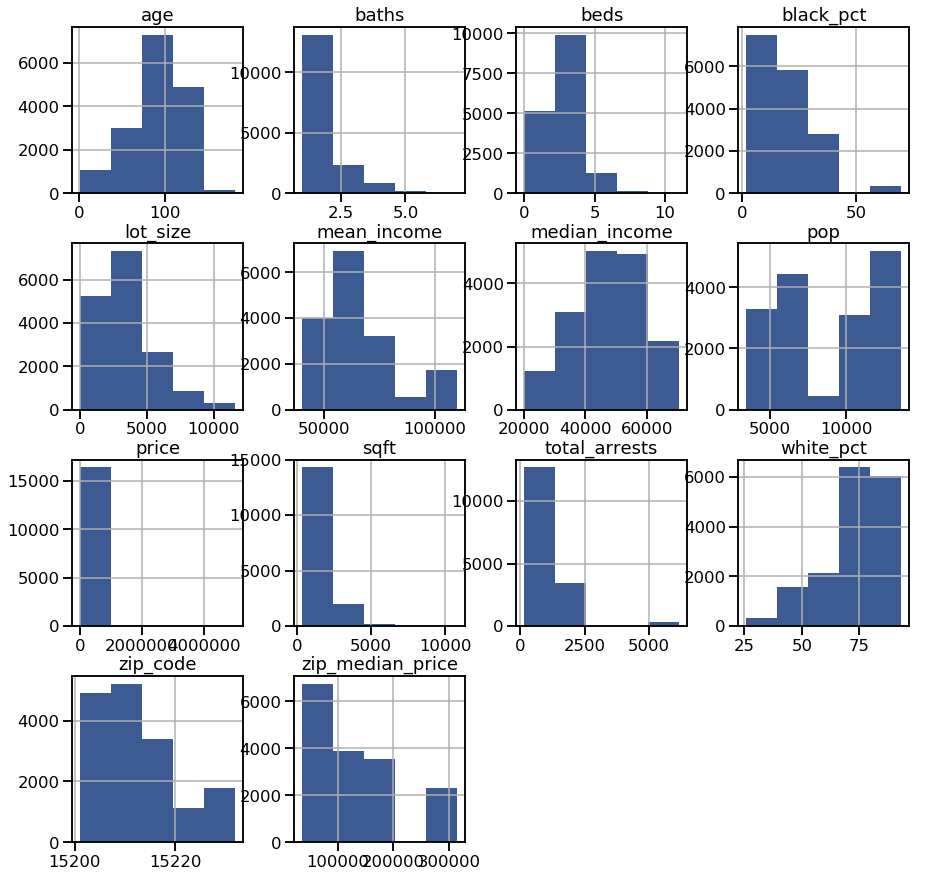

In [34]:
final_set.hist(bins=5, figsize=(15, 15))
plt.show()

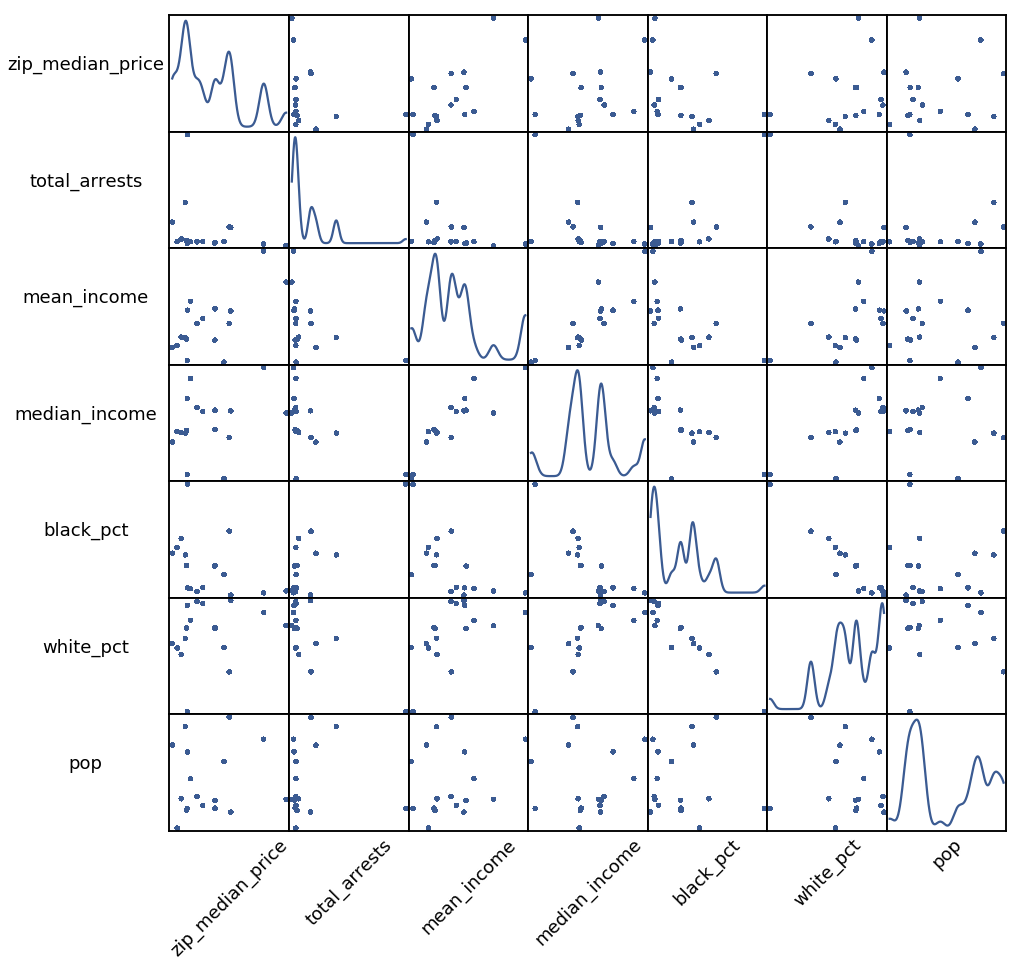

In [35]:
from pandas.plotting import scatter_matrix
sm = scatter_matrix(final_set[aggregate_attributes], figsize=(15, 15), diagonal='kde', alpha=.65)
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]
[s.get_yaxis().set_label_coords(-.7, 0.5) for s in sm.reshape(-1)]
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]
plt.show()

In [36]:
housing = final_set.drop('price', axis=1)
housing_label = final_set.price.copy()

price               1.00
baths               0.56
zip_median_price    0.54
sqft                0.52
mean_income         0.40
beds                0.26
median_income       0.22
lot_size            0.12
white_pct           0.10
pop                 0.08
age                -0.17
total_arrests      -0.18
black_pct          -0.22
Name: price, dtype: float64

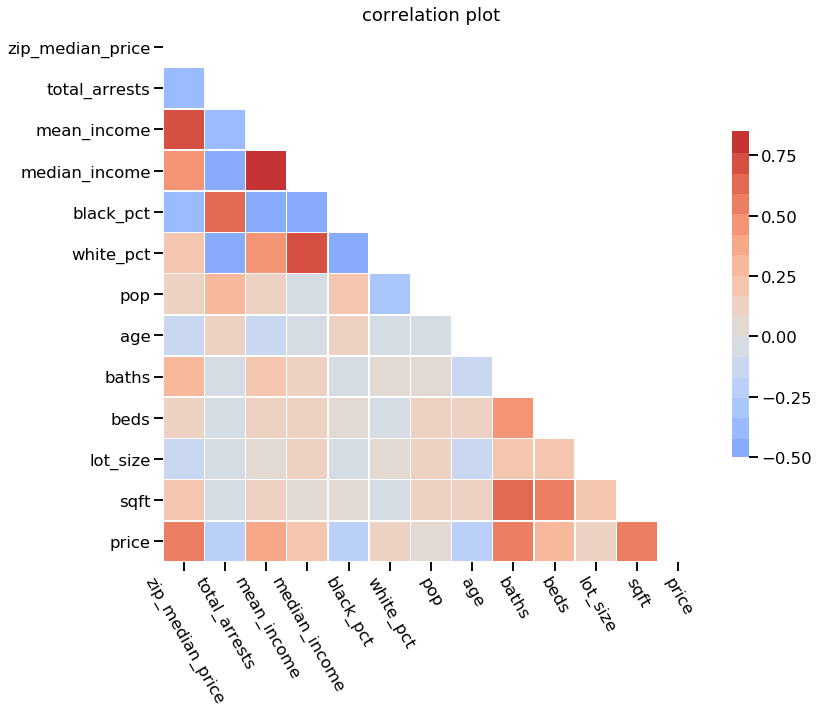

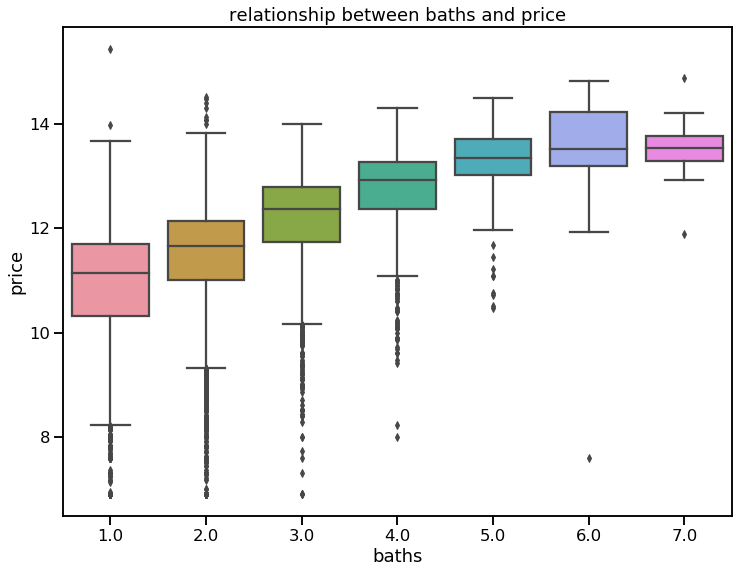

In [37]:
corr_matrix = final_set[all_num_attributes].corr()
display(corr_matrix['price'].sort_values(ascending=False))
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.color_palette('coolwarm', 20)
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.85, vmin=-.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=-60)
plt.yticks(rotation=0)
plt.title('correlation plot')
plt.show()
plt.figure(figsize=(12, 9))
sns.boxplot(x=final_set.baths, y=np.log(final_set.price))
plt.yticks(rotation=0)
plt.title('relationship between baths and price')
plt.show()

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Imputer
import tensorflow as tf
from tensorflow import keras

In [39]:
from sklearn.model_selection import train_test_split
train_feats, test_feats, train_label, test_label = train_test_split(housing, housing_label, random_state=1234)

In [40]:
num_atts = ['baths', 'zip_median_price', 'sqft', 'age']
cat_atts = ['neighborhood']
num_pipeline = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])
pipeline =  ColumnTransformer([
    ('num', num_pipeline, num_atts),
    ('cat', OneHotEncoder(), cat_atts),
])
train_feats[cat_atts] = train_feats[cat_atts].astype(str)
test_feats[cat_atts] = test_feats[cat_atts].astype(str)

In [41]:
train_feats = train_feats.reset_index()
test_feats = test_feats.reset_index()
house_train_prepared = pipeline.fit_transform(train_feats)

In [42]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
lin_reg = LinearRegression()
lin_reg.fit(house_train_prepared, train_label)
test_prepped = pipeline.transform(test_feats)
reg_pred = lin_reg.predict(test_prepped)
reg_rmse = np.sqrt(mean_squared_error(test_label, reg_pred))
print('Linear Regression RMSE:', round(reg_rmse, 2))

Linear Regression RMSE: 122533.21
CPU times: user 214 ms, sys: 20.1 ms, total: 234 ms
Wall time: 92.5 ms


In [43]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
forest_reg = RandomForestRegressor()
param_grid = [
    {'n_estimators': [100, 250, 300], 'max_features': [12, 24, 30]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(house_train_prepared, train_label)
display(grid_search.best_params_)
display(grid_search.best_estimator_)
print('Random Forest training RMSE:', round(np.sqrt(-grid_search.cv_results_['mean_test_score'].min()), 2))

{'max_features': 12, 'n_estimators': 100}

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=12, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

Random Forest training RMSE: 98950.2
CPU times: user 12.7 s, sys: 326 ms, total: 13.1 s
Wall time: 3min 38s


In [44]:
from sklearn.metrics import mean_squared_error
final_model = grid_search.best_estimator_
final_preds = final_model.predict(test_prepped)
rf_rmse = np.sqrt(mean_squared_error(test_label, final_preds))
print('Random Forest test RMSE:', round(rf_rmse, 2))

Random Forest test RMSE: 118282.91
